# 1.	Description of the Problem:

## Launch of restaurant in Downtown Toronto, ON, Canada.  

### Toronto is the provincial capital of Ontario and the most populous city in Canada, with a population of 2,731,571 in 2016.

### Toronto has diverse population and over 160 languages are spoken in the city. There are number of corporate offices in downtown Toronto.  

### https://en.wikipedia.org/wiki/Toronto

### This project will give an insight on “Restaurants” in downtown,  so that it will be easy to make decision on what type of restaurant will give more ROI.


In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd


import numpy as np # library to handle data in a vectorized manner

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('import libraries completed')

import libraries completed


# Data for the project
##   . Data will be scraped from wiki page which will give postal codes of Toronto
##   . Data will be filtered “Downtown Toronto”

In [2]:
# Get Canada Postal codes from wiki page and parse data.
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
source = requests.get(url).text
Canada_data = BeautifulSoup(source, 'lxml')
#print(source)
print('Got data from wiki')

Got data from wiki


In [3]:
# creat a new Dataframe with three columns
column_names = ['PostalCode','Borough','Neighborhood']
toronto_df = pd.DataFrame(columns = column_names)
#print(toronto_df)
# Read "Canada_data" html and get data from three columns

# loop through to find postcode, borough, neighborhood 
content = Canada_data.find('div', class_='mw-parser-output')

table = content.table.tbody
postalcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postalcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto_df = toronto_df.append({'PostalCode': postalcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

#print(toronto_df)


# clean dataframe, remove Borough "Not assigned"  and group by postal code and borough
toronto_df = toronto_df[toronto_df.Borough!='Not assigned']
toronto_df = toronto_df[toronto_df.Borough!= 0]
toronto_df.reset_index(drop = True, inplace = True)

i = 0
for i in range(0,toronto_df.shape[0]):
    if toronto_df.iloc[i][2] == 'Not assigned':
        
        toronto_df.iloc[i][2] = toronto_df.iloc[i][1]
        i = i+1

#More than one neighborhood can exist in one postal code area.  User group by and join with Comma
df = toronto_df.groupby(['PostalCode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()
#df

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [4]:
df = df.dropna()
na = 'Not assigned'
df = df[(df.PostalCode != na ) & (df.Borough != na) & (df.Neighborhood != na)]
df.shape

(103, 3)

In [5]:
toronto_latlong = 'https://cocl.us/Geospatial_data'
!wget -q -O 'toronto_m.geospatial_data.csv' toronto_latlong
geocsv_data = pd.read_csv(toronto_latlong).set_index('Postal Code')
geocsv_data.rename_axis('PostalCode', axis='index', inplace=True)
geocsv_data.head()

,Latitude,Longitude
PostalCode,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [6]:
toronto_merged = df.merge(geocsv_data,on='PostalCode', how='right')
toronto_merged.head()
toronto_merged.shape

(103, 5)

# Get Toronto Data (Borough contains Downtown Toronto)

In [7]:

toronto_data = toronto_merged[toronto_merged['Borough'].str.contains('Downtown Toronto')].reset_index(drop=True)
toronto_data

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529
1,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
3,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
4,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937
5,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
6,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
7,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
8,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568
9,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752


In [8]:
address = 'Downtown Toronto, ON'

geolocator = Nominatim(user_agent="Toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.655115, -79.380219.


# create map of Toronto using latitude and longitude values

In [9]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [10]:
# Prepare for FourSquare API
# Removed id and secret for security reasons.

CLIENT_ID = 'EETGCOKC4VJLPVXRKU0B5SXRUMKZWZVQ40N5I0VALUG000NW' # your Foursquare ID
CLIENT_SECRET = 'TMIK344D2SPUIGU4RFTDWTNQF3IR40Z44IIJOALHMSFQ2HO3' # your Foursquare Secret
VERSION = '20190703' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: EETGCOKC4VJLPVXRKU0B5SXRUMKZWZVQ40N5I0VALUG000NW
CLIENT_SECRET:TMIK344D2SPUIGU4RFTDWTNQF3IR40Z44IIJOALHMSFQ2HO3


In [11]:
#Explore 1st element - Neighborhood in data  -  Toronto Dominion Centre
i=1
toronto_data.loc[i, 'Neighborhood']

'Cabbagetown, St. James Town'

In [12]:
i=1
neighborhood_latitude = toronto_data.loc[i, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[i, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_data.loc[i, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Cabbagetown, St. James Town are 43.667967, -79.3676753.


In [13]:
# Top 50 Venues in Design Exchange, Toronto Dominion Centre
LIMIT=50
radius=500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=EETGCOKC4VJLPVXRKU0B5SXRUMKZWZVQ40N5I0VALUG000NW&client_secret=TMIK344D2SPUIGU4RFTDWTNQF3IR40Z44IIJOALHMSFQ2HO3&v=20190703&ll=43.667967,-79.3676753&radius=500&limit=50'

In [14]:
results = requests.get(url).json()
#results

In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [16]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Cranberries,Diner,43.667843,-79.369407
1,F'Amelia,Italian Restaurant,43.667536,-79.368613
2,Butter Chicken Factory,Indian Restaurant,43.667072,-79.369184
3,Kingyo Toronto,Japanese Restaurant,43.665895,-79.368415
4,Murgatroid,Restaurant,43.667381,-79.369311


In [17]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

46 venues were returned by Foursquare.


In [18]:
#Explore Neighborhoods in Toronto
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [19]:
# Call above function on each neighborhood and create a new dataframe called toronto_venues.

toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )
toronto_venues.head()

Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Mooredale House,43.678631,-79.380091,Building
1,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
2,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
3,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park
4,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail


# Filter "Restaurant" Data from Venue Category

In [20]:
# Create a Data-Frame out of it to Concentrate Only on Restaurants 

toronto_venues = toronto_venues [toronto_venues['Venue Category'].str.contains('Restaurant')].reset_index(drop=True)
toronto_venues.index = np.arange(1, len(toronto_venues)+1)

toronto_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1,"Cabbagetown, St. James Town",43.667967,-79.367675,F'Amelia,43.667536,-79.368613,Italian Restaurant
2,"Cabbagetown, St. James Town",43.667967,-79.367675,Butter Chicken Factory,43.667072,-79.369184,Indian Restaurant
3,"Cabbagetown, St. James Town",43.667967,-79.367675,Kingyo Toronto,43.665895,-79.368415,Japanese Restaurant
4,"Cabbagetown, St. James Town",43.667967,-79.367675,Murgatroid,43.667381,-79.369311,Restaurant
5,"Cabbagetown, St. James Town",43.667967,-79.367675,Kanpai Snack Bar,43.664331,-79.368065,Taiwanese Restaurant


In [21]:
print(toronto_venues.shape)


(167, 7)


In [22]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"Adelaide, King, Richmond",15,15,15,15,15,15
Berczy Park,11,11,11,11,11,11
"Cabbagetown, St. James Town",11,11,11,11,11,11
Central Bay Street,15,15,15,15,15,15
"Chinatown, Grange Park, Kensington Market",16,16,16,16,16,16
Christie,2,2,2,2,2,2
Church and Wellesley,12,12,12,12,12,12
"Commerce Court, Victoria Hotel",10,10,10,10,10,10
"Design Exchange, Toronto Dominion Centre",10,10,10,10,10,10


In [23]:
# Analyze each neighborhood
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Neighborhood,American Restaurant,Asian Restaurant,Belgian Restaurant,Brazilian Restaurant,Caribbean Restaurant,Chinese Restaurant,Colombian Restaurant,Comfort Food Restaurant,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Falafel Restaurant,Fast Food Restaurant,French Restaurant,Gluten-free Restaurant,Greek Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Latin American Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,New American Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Taiwanese Restaurant,Thai Restaurant,Theme Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant
1,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,"Cabbagetown, St. James Town",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [24]:
toronto_onehot.shape

(167, 36)

In [41]:
# Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()
toronto_grouped.shape

(16, 36)

In [42]:
num_top_venues = 10

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
                           venue  freq
0            American Restaurant  0.27
1               Asian Restaurant  0.13
2  Vegetarian / Vegan Restaurant  0.07
3           Brazilian Restaurant  0.07
4            Japanese Restaurant  0.07
5                Thai Restaurant  0.07
6           Colombian Restaurant  0.07
7               Sushi Restaurant  0.07
8             Seafood Restaurant  0.07
9       Mediterranean Restaurant  0.07


----Berczy Park----
                           venue  freq
0             Seafood Restaurant  0.18
1        Comfort Food Restaurant  0.09
2               Greek Restaurant  0.09
3              French Restaurant  0.09
4                     Restaurant  0.09
5    Eastern European Restaurant  0.09
6             Italian Restaurant  0.09
7                Thai Restaurant  0.09
8  Vegetarian / Vegan Restaurant  0.09
9             Belgian Restaurant  0.09


----Cabbagetown, St. James Town----
                      venue  freq
0              

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Adelaide, King, Richmond",American Restaurant,Asian Restaurant,Brazilian Restaurant,Greek Restaurant,Vegetarian / Vegan Restaurant
1,Berczy Park,Seafood Restaurant,Italian Restaurant,Restaurant,French Restaurant,Vegetarian / Vegan Restaurant
2,"Cabbagetown, St. James Town",Restaurant,Italian Restaurant,Indian Restaurant,Thai Restaurant,Taiwanese Restaurant
3,Central Bay Street,Italian Restaurant,Chinese Restaurant,Portuguese Restaurant,Falafel Restaurant,Vegetarian / Vegan Restaurant
4,"Chinatown, Grange Park, Kensington Market",Mexican Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Caribbean Restaurant,Ramen Restaurant


In [45]:
# set number of clusters
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]



array([0, 0, 1, 2, 2, 1, 1, 0, 0, 0], dtype=int32)

In [46]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = toronto_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,NaN,NaN,NaN,NaN,NaN,NaN
1,M4X,Downtown Toronto,"Cabbagetown, St. James Town",43.667967,-79.367675,1.0,Restaurant,Italian Restaurant,Indian Restaurant,Thai Restaurant,Taiwanese Restaurant
2,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,1.0,Restaurant,Japanese Restaurant,Vietnamese Restaurant,Ethiopian Restaurant,Indian Restaurant
3,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,1.0,Mexican Restaurant,Restaurant,Italian Restaurant,French Restaurant,Dumpling Restaurant
4,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,2.0,Ramen Restaurant,Italian Restaurant,Fast Food Restaurant,Vegetarian / Vegan Restaurant,Japanese Restaurant


In [47]:
# create map
import math
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    if math.isnan(cluster):
       
        cluster=1
    label = folium.Popup(str(poi) + ' Cluster ' + str(int(cluster)), parse_html=True)
    
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters


In [58]:
# Remove Venue Category="Restaurant"

toronto_venues_temp = toronto_venues[toronto_venues['Venue Category']!= 'Restaurant'].reset_index(drop=True)
toronto_venues_temp
 
print (toronto_venues_temp['Venue Category'].unique())
print('')
print (toronto_venues_temp['Venue Category'].value_counts())

['Italian Restaurant' 'Indian Restaurant' 'Japanese Restaurant'
 'Taiwanese Restaurant' 'Caribbean Restaurant' 'Thai Restaurant'
 'Chinese Restaurant' 'Theme Restaurant' 'Ramen Restaurant'
 'Mexican Restaurant' 'Vietnamese Restaurant' 'Ethiopian Restaurant'
 'Sushi Restaurant' 'French Restaurant' 'Vegetarian / Vegan Restaurant'
 'American Restaurant' 'Fast Food Restaurant' 'Middle Eastern Restaurant'
 'Modern European Restaurant' 'Latin American Restaurant'
 'New American Restaurant' 'Seafood Restaurant' 'Greek Restaurant'
 'Belgian Restaurant' 'Comfort Food Restaurant'
 'Eastern European Restaurant' 'Portuguese Restaurant'
 'Falafel Restaurant' 'Asian Restaurant' 'Colombian Restaurant'
 'Brazilian Restaurant' 'Mediterranean Restaurant'
 'Gluten-free Restaurant' 'Dumpling Restaurant']

Italian Restaurant               16
Japanese Restaurant              15
Seafood Restaurant               11
American Restaurant              11
Vegetarian / Vegan Restaurant     9
Mexican Restaurant     

In [64]:
# create a dataframe of top 10 categories
toronto_venues_temp_10 = toronto_venues_temp['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
toronto_venues_temp_10=toronto_venues_temp_10.reset_index()


toronto_venues_temp_10.rename(index=str, columns={"index": "Venue Category", "frequency": "Frequency"}, inplace=True)
toronto_venues_temp_10

,Venue Category,Frequency
0,Italian Restaurant,16
1,Japanese Restaurant,15
2,Seafood Restaurant,11
3,American Restaurant,11
4,Vegetarian / Vegan Restaurant,9
5,Mexican Restaurant,8
6,Thai Restaurant,7
7,Chinese Restaurant,5
8,Sushi Restaurant,5
9,Ramen Restaurant,5


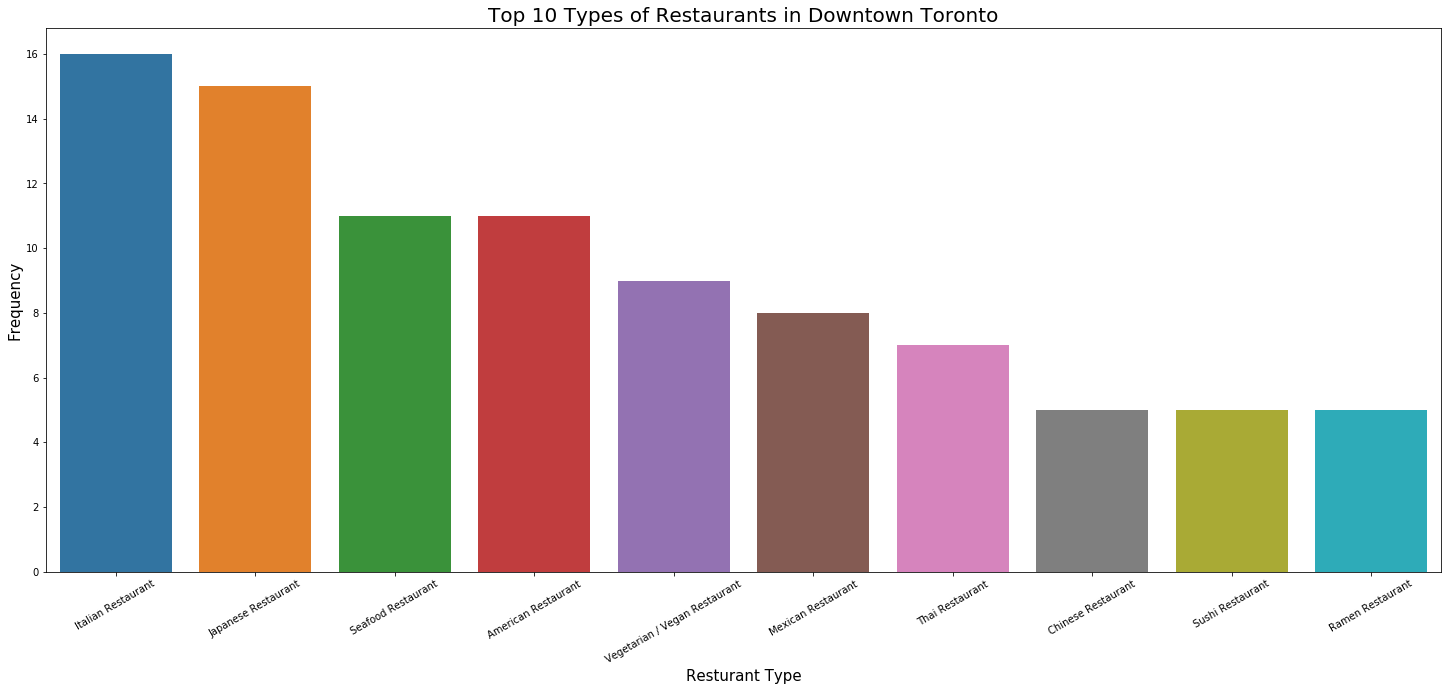

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(25,10))
s=sns.barplot(x="Venue Category", y="Frequency", data=toronto_venues_temp_10)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('Top 10 Types of Restaurants in Downtown Toronto', fontsize=20)
plt.xlabel("Resturant Type", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Resturants_Types_10_Downtown_Toronto.png", dpi=30)
plt.show()

# Conclusion
### Based on above analysis and plot, we can start either most frequent occuring "Italian" resturant OR "Indian" as it is not # available in top 10 resturants. 

### But before making any business decision, we have to do more data analysis and consider other ### factors such as why some type of restaurants are not in top-10, any failures for such type of resturants etc...
